In [34]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import *
from sklearn import metrics
import codecs
import re

# from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import ward, dendrogram

In [35]:
random_state = 42

Run the following code below to use custom python modules the team has created. 

In [36]:
import os
import sys

# directory_path = os.path.abspath(os.path.join(".."))
# if directory_path not in sys.path:
#    sys.path.append("../functions/")

# import feature_engineering

In [37]:
# from functions import feature_engineering

In [38]:
audio_path, artists_path, playlists_path = (
    r"../../data/spotify_audio_features.json",
    r"../../data/spotify_artists.json",
    r"../../data/spotify_top_50_playlists.json",
)

In [39]:
def add_features(audio_features: pd.DataFrame, artists: pd.DataFrame, playlists: pd.DataFrame) -> list:
    """add features to read in spotify data

    Args:
        audio_features (pd.DataFrame): audio features
        artists (pd.DataFrame): artists
        playlists (pd.DataFrame): playlists
    Returns:
        audio_features (pd.DataFrame): audio features w/ added features
        artists (pd.DataFrame): artists w/ added features
        playlists (pd.DataFrame): playlists w/ added features
    """
    # --- playlists --- #
    # add market ID to playlists
    playlists["market_id"] = (
        playlists["playlist_name"]
        .apply(lambda x: re.sub(r"Top Songs - ", "", x))
        .apply(lambda x: re.sub(r"\s+", "_", x).lower())
    )

    # add # of available markets by counting ","
    # it is a list column so we need to make it a string first
    playlists["num_avail_markets"] = playlists["available_markets"].apply(lambda x: len(str(x).split(",")))

    # count # of artists per song
    playlists["num_artists"] = playlists["artist_ids"].apply(lambda x: sum(1 for item in x if "id" in item))

    # create rank variable, which is row number grouped by market_id
    playlists["playlist_rank"] = playlists.groupby("market_id").cumcount() + 1

    # drop some columns
    playlists.drop(columns=["available_markets", "playlist_name"], inplace=True)

    # rename some columns
    playlists.rename(columns={"popularity": "track_popularity"}, inplace=True)

    # -- artists -- #
    artists.rename(columns={"popularity": "artist_popularity"}, inplace=True)

    return audio_features, artists, playlists


def get_data(audio_path: str, artists_path: str, playlists_path: str) -> list:
    """
    read in raw spotify api json data from local files.

    Args:
        audio_path (str): path to audio features json
        artists_path (str): path to artists json
        playlists_path (str): path to playlists json

    Returns:
        audio_features (pd.DataFrame): audio features
        artists (pd.DataFrame): artists
        playlists (pd.DataFrame): playlists
    """
    # audio features
    # with open(audio_path) as f:
    audio_features = pd.read_json(codecs.open(audio_path, "r", "utf-8"))

    # artists
    # with open(artists_path) as f:
    artists = pd.read_json(codecs.open(artists_path, "r", "utf-8"))

    # playlists
    # with open(playlists_path) as f:
    playlists = pd.read_json(codecs.open(playlists_path, "r", "utf-8"))

    # return list
    return add_features(audio_features, artists, playlists)

In [40]:
audio_df, artist_df, playlist_df = get_data(audio_path, artists_path, playlists_path)

In [41]:
display(audio_df.head())
display(artist_df.head())
display(playlist_df.head())

,track_id,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,7r8FHPasw67Nl4Hqyd4685,0.638,0.716,6,-7.287,0,0.0696,0.160,0.00000,0.3660,0.833,150.124,157600,4
1,2RLdkXSaiQjRbey5pvP8Kt,0.401,0.394,1,-6.655,1,0.0324,0.748,0.00000,0.0993,0.327,129.740,274387,4
2,1LiN0Z98FkR1t0m8KmLcAH,0.790,0.631,8,-5.549,0,0.0425,0.437,0.00000,0.1580,0.889,94.039,190005,4
3,7bFFUPBiF15n8m8RziqS4o,0.581,0.558,5,-10.404,1,0.0432,0.627,0.00022,0.1020,0.271,76.992,281494,4
4,0uHbsPVRr12ERCABBWVbe0,0.587,0.810,9,-3.519,0,0.0962,0.161,0.00000,0.1210,0.424,157.863,184488,4


,artist_id,artist_name,followers,genres,artist_popularity
0,1Kjs5u8GQf6zCFdTj6SI9E,Malik Montana,1038436,"[polish drill, polish hip hop, polish trap]",64
1,2CKOmarVWvWqkNWUatHCex,Ana Castela,2932225,"[agronejo, funk rj, sertanejo pop]",82
2,7krakxeyEmge6pzTthKNyg,Bausa,8035,[russelater],52
3,66RfYVdftqnuHRicyClgL0,Dharius,2313917,[mexican hip hop],69
4,29zSTMejPhY0m7kwNQ9SPI,Lola Amour,709383,[opm],67


,track_id,track_name,playlist_id,album_type,album_id,artist_ids,explicit,track_popularity,market_id,num_avail_markets,num_artists,playlist_rank
0,2IGMVunIBsBLtEQyoI1Mu7,Paint The Town Red,37i9dQZEVXbNG2KDcFcKOF,single,54dZypaXHAIDzBe9ujAZ63,[{'id': '5cj0lLjcoR7YOSnhnX0Po5'}],True,100,global,183,1,1
1,7x9aauaA9cu6tyfpHnqDLo,Seven (feat. Latto) (Explicit Ver.),37i9dQZEVXbNG2KDcFcKOF,single,53985D8g3JcGBoULSOYYKX,"[{'id': '6HaGTQPmzraVmaVxvz6EUc'}, {'id': '3Md...",True,97,global,184,2,2
2,1BxfuPKGuaTgP7aM0Bbdwr,Cruel Summer,37i9dQZEVXbNG2KDcFcKOF,album,1NAmidJlEaVgA3MpcPFYGq,[{'id': '06HL4z0CvFAxyc27GXpf02'}],False,98,global,184,1,3
3,1kuGVB7EU95pJObxwvfwKS,vampire,37i9dQZEVXbNG2KDcFcKOF,album,1xJHno7SmdVtZAtXbdbDZp,[{'id': '1McMsnEElThX1knmY4oliG'}],True,93,global,183,1,4
4,5RqSsdzTNPX1uzkmlHCFvK,QLONA,37i9dQZEVXbNG2KDcFcKOF,album,0FqAaUEyKCyUNFE1uQPZ7i,"[{'id': '790FomKkXshlbRYZFtlgla'}, {'id': '12G...",True,91,global,182,2,5


In [42]:
display(audio_df.info(), artist_df.info(), playlist_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1680 entries, 0 to 1679
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   track_id          1680 non-null   object 
 1   danceability      1680 non-null   float64
 2   energy            1680 non-null   float64
 3   key               1680 non-null   int64  
 4   loudness          1680 non-null   float64
 5   mode              1680 non-null   int64  
 6   speechiness       1680 non-null   float64
 7   acousticness      1680 non-null   float64
 8   instrumentalness  1680 non-null   float64
 9   liveness          1680 non-null   float64
 10  valence           1680 non-null   float64
 11  tempo             1680 non-null   float64
 12  duration_ms       1680 non-null   int64  
 13  time_signature    1680 non-null   int64  
dtypes: float64(9), int64(4), object(1)
memory usage: 183.9+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1682 entries, 0 to 1681
Dat

None

None

None

In [63]:
df_join = audio_df.merge(playlist_df, on="track_id")
df_join.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2899 entries, 0 to 2898
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   track_id           2899 non-null   object 
 1   danceability       2899 non-null   float64
 2   energy             2899 non-null   float64
 3   key                2899 non-null   int64  
 4   loudness           2899 non-null   float64
 5   mode               2899 non-null   int64  
 6   speechiness        2899 non-null   float64
 7   acousticness       2899 non-null   float64
 8   instrumentalness   2899 non-null   float64
 9   liveness           2899 non-null   float64
 10  valence            2899 non-null   float64
 11  tempo              2899 non-null   float64
 12  duration_ms        2899 non-null   int64  
 13  time_signature     2899 non-null   int64  
 14  track_name         2899 non-null   object 
 15  playlist_id        2899 non-null   object 
 16  album_type         2899 

In [44]:
df_join.head()

,track_id,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,...,playlist_id,album_type,album_id,artist_ids,explicit,track_popularity,market_id,num_avail_markets,num_artists,playlist_rank
0,7r8FHPasw67Nl4Hqyd4685,0.638,0.716,6,-7.287,0,0.0696,0.160,0.00000,0.3660,...,37i9dQZEVXbLWYFZ5CkSvr,single,5WJLZ54uK7ni636O65EztT,[{'id': '1Kj6Km5IuLGKt2cxuhSgLm'}],True,64,norway,184,1,23
1,2RLdkXSaiQjRbey5pvP8Kt,0.401,0.394,1,-6.655,1,0.0324,0.748,0.00000,0.0993,...,37i9dQZEVXbJZGli0rRP3r,album,5ITErfEiF1nEo8KTRgLv43,[{'id': '75MOYjGEyyH5U4ZFHOPvxR'}],False,59,south_korea,184,1,33
2,1LiN0Z98FkR1t0m8KmLcAH,0.790,0.631,8,-5.549,0,0.0425,0.437,0.00000,0.1580,...,37i9dQZEVXbMPoK06pe7d6,single,464FQ8gr0oKlQ1a0TCK4Yj,"[{'id': '2R21vXR83lH98kGeO99Y66'}, {'id': '77i...",False,83,dominican_republic,180,2,43
3,1LiN0Z98FkR1t0m8KmLcAH,0.790,0.631,8,-5.549,0,0.0425,0.437,0.00000,0.1580,...,37i9dQZEVXbMGcjiWgg253,single,464FQ8gr0oKlQ1a0TCK4Yj,"[{'id': '2R21vXR83lH98kGeO99Y66'}, {'id': '77i...",False,83,peru,180,2,41
4,7bFFUPBiF15n8m8RziqS4o,0.581,0.558,5,-10.404,1,0.0432,0.627,0.00022,0.1020,...,37i9dQZEVXbKZyn1mKjmIl,single,7q2bB2NNFlNbtqadbn55pL,[{'id': '6d0dLenjy5CnR5ZMn2agiV'}],False,63,vietnam,183,1,41


Let's create a dataframe merging the playlist tracks for each country and track statistics from spotify.

In [93]:
def create_merged_df(df1: pd.DataFrame, df2: pd.DataFrame, merged_feature: str = "track_id"):
    merged_df = df1.merge(df2, on=merged_feature)

    return merged_df

In [97]:
df_join = create_merged_df(audio_df, playlist_df)
df_join.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2899 entries, 0 to 2898
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   track_id           2899 non-null   object 
 1   danceability       2899 non-null   float64
 2   energy             2899 non-null   float64
 3   key                2899 non-null   int64  
 4   loudness           2899 non-null   float64
 5   mode               2899 non-null   int64  
 6   speechiness        2899 non-null   float64
 7   acousticness       2899 non-null   float64
 8   instrumentalness   2899 non-null   float64
 9   liveness           2899 non-null   float64
 10  valence            2899 non-null   float64
 11  tempo              2899 non-null   float64
 12  duration_ms        2899 non-null   int64  
 13  time_signature     2899 non-null   int64  
 14  track_name         2899 non-null   object 
 15  playlist_id        2899 non-null   object 
 16  album_type         2899 

If we check the rows with the merged dataframe and the original playlist dataframe, we see there is a missing track (2900 rows vs 2899). The following function will look for the missing track or tracks

In [103]:
def find_missing_tracks(merged_df: pd.DataFrame, track_df: pd.DataFrame = playlist_df):
    missing_track_df = track_df[~track_df["track_id"].isin(merged_df["track_id"])].dropna()

    return missing_track_df

In [109]:
missing_tracks_df = find_missing_tracks(df_join)
missing_tracks_df

,track_id,track_name,playlist_id,album_type,album_id,artist_ids,explicit,track_popularity,market_id,num_avail_markets,num_artists,playlist_rank
1295,6O7pAOsUm3d9R37vYdQnG5,Lovebars,37i9dQZEVXbJUPkgaWZcWG,album,37uJcI0dW70M5Hbg1WearN,"[{'id': '5dXlc7MnpaTeUIsHLVe3n4'}, {'id': '7Bg...",False,68,italy,183,2,46


In order to add this missing track to our training data we need to input missing variable data. Since this information is unavailable from the source (Spotify), we will take the mean value of each measurement in each country playlist. We will assume that the missing tracks will have similar stats to other tracks in its country of origin. The function below will create a stat dataframe for the each country that we can then use to fill in missing information for the track or tracks. 

In [115]:
def create_country_stats(merged_df: pd.DataFrame, stat: str = "mean"):
    calc_df = df_join.select_dtypes(exclude=["object", "bool"])

    calc_df2 = df_join[calc_df.columns.tolist() + ["market_id"]].drop(
        ["track_popularity", "num_avail_markets", "playlist_rank", "num_artists"], axis=1
    )

    if stat == "mean":
        stat_df = calc_df2.groupby("market_id").mean().reset_index()

    elif stat == "variance" or stat == "var":
        stat_df = calc_df2.groupby("market_id").var().reset_index()

    elif stat == "std":
        stat_df = calc_df2.groupby("market_id").std().reset_index()

    elif stat == "max":
        stat_df = calc_df2.groupby("market_id").max().reset_index()

    elif stat == "min":
        stat_df = calc_df2.groupby("market_id").min().reset_index()

    elif stat == "median":
        stat_df = calc_df2.groupby("market_id").median().reset_index()

    return stat_df

In [116]:
mean_df = create_country_stats(df_join)
mean_df.head(10)

,market_id,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,argentina,0.71360,0.681500,6.58,-5.26474,0.56,0.099504,0.204713,0.000037,0.180834,0.629460,116.54620,180435.52,3.92
1,australia,0.63108,0.648162,5.08,-6.76162,0.76,0.081830,0.271935,0.009575,0.161508,0.530140,128.73094,199307.84,3.88
2,austria,0.68354,0.667262,5.20,-6.92660,0.54,0.108322,0.235301,0.019419,0.150992,0.481160,130.02064,171698.04,3.92
3,belarus,0.68412,0.667200,4.62,-6.71352,0.48,0.099148,0.184487,0.062134,0.207644,0.481682,128.87126,151340.04,3.96
4,belgium,0.66792,0.702742,4.96,-6.36422,0.46,0.107370,0.251751,0.023322,0.169942,0.550520,130.09938,187924.68,3.88
5,brazil,0.69118,0.738200,5.88,-4.93606,0.56,0.108008,0.371288,0.001545,0.359040,0.658960,132.43876,166263.44,4.00
6,canada,0.61534,0.593702,5.24,-6.73580,0.64,0.082652,0.347049,0.003016,0.178946,0.486540,125.32364,202735.78,3.84
7,chile,0.70890,0.691320,5.82,-6.09794,0.54,0.097294,0.225940,0.019490,0.166546,0.651180,115.62412,195849.18,3.84
8,colombia,0.76404,0.703740,4.84,-5.11196,0.36,0.123370,0.267254,0.018074,0.157500,0.593380,121.58590,187218.22,3.92
9,czech_republic,0.69150,0.666462,5.24,-7.39578,0.40,0.125426,0.226099,0.031040,0.172678,0.500400,125.90296,181331.26,3.94


In [108]:
# playlist_df[~playlist_df["track_id"].isin(df_join["track_id"])].dropna()["track_id"].values().tolist()

In [129]:
# track_df = playlist_df[~playlist_df["track_id"].isin(df_join["track_id"])].dropna()
# track_df

In [110]:
# calc_df = df_join.select_dtypes(exclude=["object", "bool"])
# calc_df2 = df_join[calc_df.columns.tolist() + ["market_id"]].drop(['track_popularity', 'num_avail_markets', 'playlist_rank', 'num_artists'], axis=1)
# mean_df = calc_df2.groupby('market_id').mode()

With the country statistics for songs we will fill in the average statistic in each category for the missing track and then add that missing track to our merged dataframe. The result should have 2900 rows. This is 50 top songs across 58 countries. 

In [117]:
def add_missing_tracks(merged_df: pd.DataFrame, missing_tracks_df: pd.DataFrame, stats_df: pd.DataFrame):
    missing_stats_df = missing_tracks_df.merge(stats_df, on="market_id")

    final_df = pd.concat([merged_df, missing_stats_df], ignore_index=True)

    return final_df

In [118]:
df_join_final = add_missing_tracks(df_join, missing_tracks_df, mean_df)
df_join_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2900 entries, 0 to 2899
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   track_id           2900 non-null   object 
 1   danceability       2900 non-null   float64
 2   energy             2900 non-null   float64
 3   key                2900 non-null   float64
 4   loudness           2900 non-null   float64
 5   mode               2900 non-null   float64
 6   speechiness        2900 non-null   float64
 7   acousticness       2900 non-null   float64
 8   instrumentalness   2900 non-null   float64
 9   liveness           2900 non-null   float64
 10  valence            2900 non-null   float64
 11  tempo              2900 non-null   float64
 12  duration_ms        2900 non-null   float64
 13  time_signature     2900 non-null   float64
 14  track_name         2900 non-null   object 
 15  playlist_id        2900 non-null   object 
 16  album_type         2900 

In [119]:
# missing_df = track_df.merge(mean_df, on='market_id')
# missing_df.info()

In [120]:
# df_join = pd.concat([df_join,missing_df], ignore_index=True)
# df_join.info()

In [121]:
num_k = len(df_join_final.market_id.unique())
num_k

58

In [122]:
len(df_join_final)

2900

In [69]:
# generate number labels per market to compare with model
# hot_code_labels = np.arange(58)
# hot_code_labels

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57])

In [70]:
# sort markets by alphabetical order and create dictionary for mapping
# markets = np.sort(df_join.market_id.unique()).tolist()
# markets
# market_dic = {markets[i]: hot_code_labels[i] for i in range(len(hot_code_labels))}
# market_dic
# new column for market_label is created in dataframe
# df_join["market_label"] = df_join["market_id"].map(market_dic)
# df_join[["market_id","market_label"]].head(10)

In [124]:
def create_training_data(final_merged_df: pd.DataFrame, outcome_variable: str, excluded_features: list):
    # outcome variable is the y training label aimed for by model
    # excluded features are columns from the merged dataframe that should be dropped from training

    y_train = final_merged_df[outcome_variable].tolist()

    X_train = final_merged_df.select_dtypes(exclude=["object", "bool"])

    data_drop_cols = excluded_features

    X_train.drop(data_drop_cols, axis=1, inplace=True)

    return X_train, y_train

In [125]:
X_train, y_train = create_training_data(df_join_final, "market_id", ["playlist_rank", "track_popularity"])

In [126]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2900 entries, 0 to 2899
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   danceability       2900 non-null   float64
 1   energy             2900 non-null   float64
 2   key                2900 non-null   float64
 3   loudness           2900 non-null   float64
 4   mode               2900 non-null   float64
 5   speechiness        2900 non-null   float64
 6   acousticness       2900 non-null   float64
 7   instrumentalness   2900 non-null   float64
 8   liveness           2900 non-null   float64
 9   valence            2900 non-null   float64
 10  tempo              2900 non-null   float64
 11  duration_ms        2900 non-null   float64
 12  time_signature     2900 non-null   float64
 13  num_avail_markets  2900 non-null   int64  
 14  num_artists        2900 non-null   int64  
dtypes: float64(13), int64(2)
memory usage: 340.0 KB


In [71]:
X = df_join.select_dtypes(exclude=["object", "bool"])

# drop columns that may be too big a factor for cluster
data_drop_cols = ["market_label", "playlist_rank", "track_popularity"]
X.drop(data_drop_cols, axis=1, inplace=True)
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2900 entries, 0 to 2899
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   danceability       2900 non-null   float64
 1   energy             2900 non-null   float64
 2   key                2900 non-null   float64
 3   loudness           2900 non-null   float64
 4   mode               2900 non-null   float64
 5   speechiness        2900 non-null   float64
 6   acousticness       2900 non-null   float64
 7   instrumentalness   2900 non-null   float64
 8   liveness           2900 non-null   float64
 9   valence            2900 non-null   float64
 10  tempo              2900 non-null   float64
 11  duration_ms        2900 non-null   float64
 12  time_signature     2900 non-null   float64
 13  num_avail_markets  2900 non-null   int64  
 14  num_artists        2900 non-null   int64  
dtypes: float64(13), int64(2)
memory usage: 340.0 KB


In [127]:
from sklearn.preprocessing import StandardScaler

X_scaled = StandardScaler().fit_transform(X_train)

In [ ]:
# kmeans = KMeans(n_clusters=num_k, random_state=random_state)
# kmeans.fit(X_scaled)

In [128]:
from k_means_constrained import KMeansConstrained

kmeans = KMeansConstrained(n_clusters=58, size_min=50, size_max=50, random_state=random_state)
kmeans.fit(X_scaled)

KMeansConstrained(copy_x=True, init='k-means++', max_iter=300, n_clusters=58,
         n_init=10, n_jobs=1, random_state=42, size_max=50, size_min=50,
         tol=0.0001, verbose=False)

In [74]:
# kmeans.cluster_centers_.shape

df_join["cluster"] = kmeans.labels_
# df_join["centroid"] = kmeans.cluster_centers_
df_join.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2900 entries, 0 to 2899
Data columns (total 27 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   track_id           2900 non-null   object 
 1   danceability       2900 non-null   float64
 2   energy             2900 non-null   float64
 3   key                2900 non-null   float64
 4   loudness           2900 non-null   float64
 5   mode               2900 non-null   float64
 6   speechiness        2900 non-null   float64
 7   acousticness       2900 non-null   float64
 8   instrumentalness   2900 non-null   float64
 9   liveness           2900 non-null   float64
 10  valence            2900 non-null   float64
 11  tempo              2900 non-null   float64
 12  duration_ms        2900 non-null   float64
 13  time_signature     2900 non-null   float64
 14  track_name         2900 non-null   object 
 15  playlist_id        2900 non-null   object 
 16  album_type         2900 

In [75]:
import matplotlib.pyplot as plt

In [ ]:
def plot_features(df: pd.DataFrame, feature: str, features: list, label: str):
    # features are a list of features from the data to be compared in plots.

    plot_feats = [f for f in features if f != feature]

    fig, axs = plt.subplots(1, len(plot_feats), sharey=True)

    for feat, ax in zip(plot_feats, axs.ravel()):
        ax.scatter(df[feat], df[feature], c=df[label])

    return plt.show()

In [ ]:
feature = "danceability"
features = X.columns.tolist()
plot_feats = [f for f in features if f != feature]
# len(plot_feats)
# fig, axs = plt.subplots(8, 1, figsize=(15, 45))

# for feat, ax in zip(plot_feats, axs.ravel()):
#    ax[0, ]

# for i in range(len(plot_feats)):
#   axs[0][i].scatter(df_join[plot_feats[i]], df_join[feature], c=df_join["cluster"])


# axs[0].scatter(df_join["energy"], df_join["danceability"], c=df_join["cluster"])
# axs[1].scatter(df_join["key"], df_join["danceability"], c=df_join["cluster"])
# axs[2].scatter(df_join["loudness"], df_join["danceability"], c=df_join["cluster"])
# axs[3].scatter(df_join["mode"], df_join["danceability"], c=df_join["cluster"])
# axs[4].scatter(df_join["speechiness"], df_join["danceability"], c=df_join["cluster"])
# axs[5].scatter(df_join["acousticness"], df_join["danceability"], c=df_join["cluster"])
# axs[6].scatter(df_join["instrumentalness"], df_join["danceability"], c=df_join["cluster"])
# axs[7].scatter(df_join["liveness"], df_join["danceability"], c=df_join["cluster"])

# plt.show()

In [ ]:
# features = X.columns.tolist()
# plot_features(df_join, "danceability", features, "cluster")

: 

In [76]:
cols1 = X.columns.tolist()
cols2 = ["market_id", "playlist_rank", "cluster"]
analysis_df = df_join[cols1 + cols2]

analysis_df.head(10)

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,num_avail_markets,num_artists,market_id,playlist_rank,cluster
0,0.638,0.716,6.0,-7.287,0.0,0.0696,0.160,0.000000,0.3660,0.833,150.124,157600.0,4.0,184,1,norway,23,8
1,0.401,0.394,1.0,-6.655,1.0,0.0324,0.748,0.000000,0.0993,0.327,129.740,274387.0,4.0,184,1,south_korea,33,46
2,0.790,0.631,8.0,-5.549,0.0,0.0425,0.437,0.000000,0.1580,0.889,94.039,190005.0,4.0,180,2,dominican_republic,43,39
3,0.790,0.631,8.0,-5.549,0.0,0.0425,0.437,0.000000,0.1580,0.889,94.039,190005.0,4.0,180,2,peru,41,39
4,0.581,0.558,5.0,-10.404,1.0,0.0432,0.627,0.000220,0.1020,0.271,76.992,281494.0,4.0,183,1,vietnam,41,56
5,0.587,0.810,9.0,-3.519,0.0,0.0962,0.161,0.000000,0.1210,0.424,157.863,184488.0,4.0,183,1,finland,45,26
6,0.639,0.286,5.0,-7.472,0.0,0.0397,0.945,0.000000,0.1200,0.393,133.851,197015.0,4.0,184,1,israel,43,12
7,0.522,0.492,0.0,-12.356,0.0,0.1650,0.480,0.000002,0.5280,0.551,77.656,227691.0,4.0,184,2,belarus,33,9
8,0.522,0.492,0.0,-12.356,0.0,0.1650,0.480,0.000002,0.5280,0.551,77.656,227691.0,4.0,184,2,kazakhstan,44,9
9,0.878,0.309,6.0,-9.548,1.0,0.4750,0.283,0.000000,0.1010,0.637,76.008,152368.0,4.0,183,1,south_africa,28,54


In [77]:
# len(analysis_df[analysis_df.cluster == 16]['market_id'].unique())
country_map_dic = {}
country_counts_dic = {}
clusters = []
countries = []

for c in np.sort(analysis_df.cluster.unique()).tolist():
    clusters.append(c)
    countries.append(len(analysis_df[analysis_df.cluster == c]["market_id"].unique()))
    country_map_dic[c] = len(analysis_df[analysis_df.cluster == c]["market_id"].unique())
country_counts_dic["clusters"] = clusters
country_counts_dic["countries"] = countries

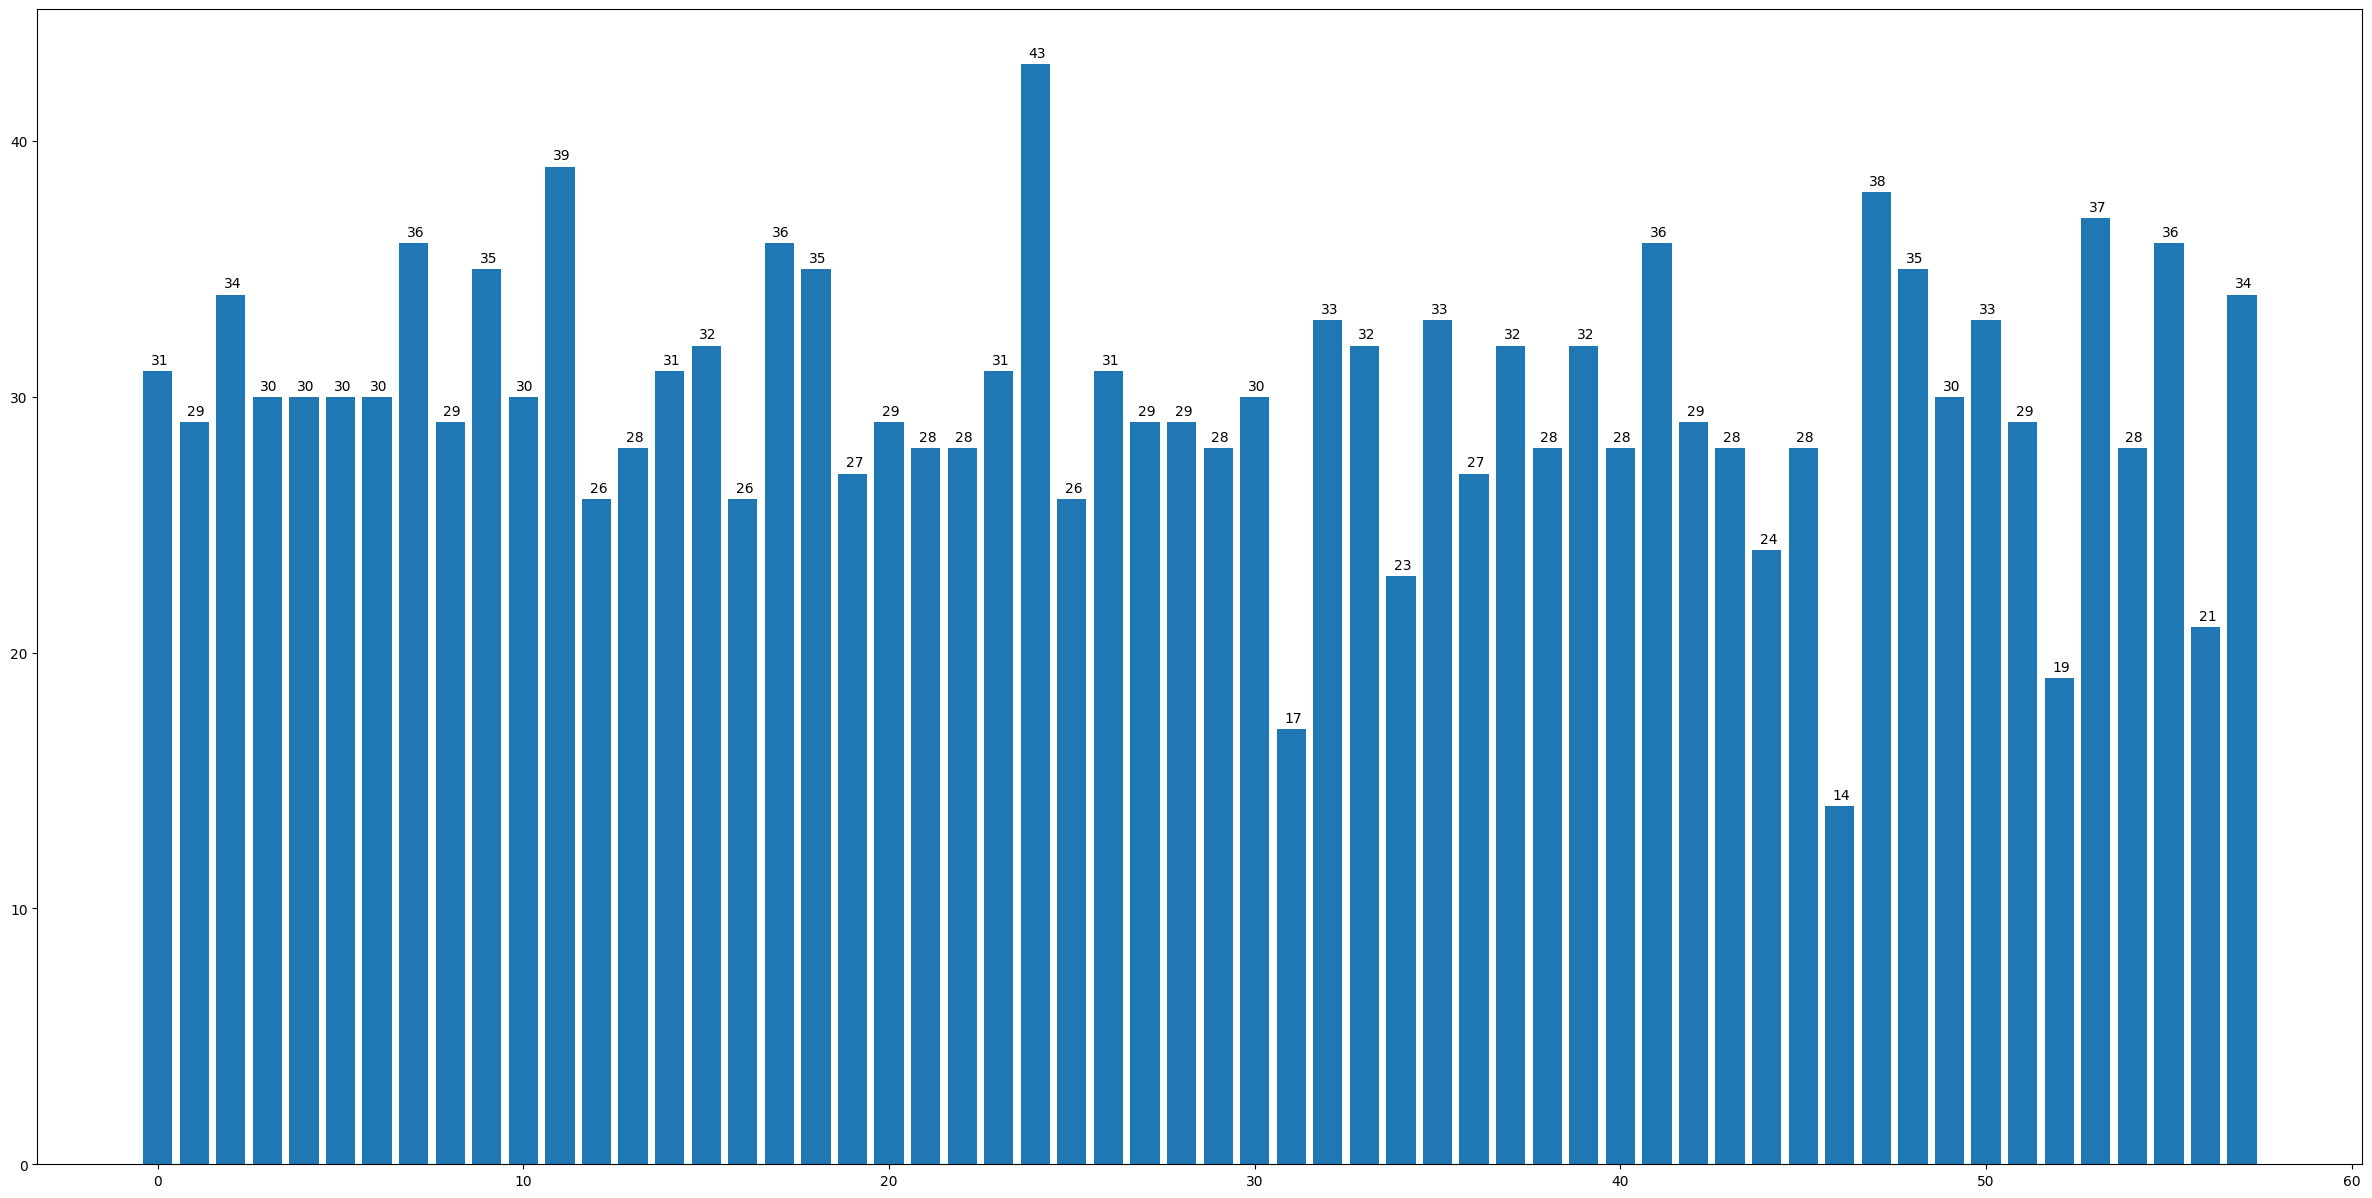

In [78]:
# [k:v for k,v in country_counts_dic.items()]

plot_df = pd.DataFrame(country_counts_dic)  # ), index = np.arange(len(country_counts_dic)))

fig, ax = plt.subplots(figsize=(30, 15))

annotations = plot_df["countries"].tolist()
ax.bar(plot_df["clusters"], plot_df["countries"])
# ax.setxticks()
for xi, yi, text in zip(plot_df["clusters"], plot_df["countries"], annotations):
    ax.annotate(text, xy=(xi, yi), xycoords="data", xytext=(-5, 5), textcoords="offset points")

In [79]:
analysis_df["countries"] = analysis_df.cluster.map(lambda x: country_map_dic[x])
analysis_df.head(10)

C:\Users\Brandyn\AppData\Local\Temp\ipykernel_29812\2715638971.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  analysis_df["countries"] = analysis_df.cluster.map(lambda x: country_map_dic[x])


,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,num_avail_markets,num_artists,market_id,playlist_rank,cluster,countries
0,0.638,0.716,6.0,-7.287,0.0,0.0696,0.160,0.000000,0.3660,0.833,150.124,157600.0,4.0,184,1,norway,23,8,29
1,0.401,0.394,1.0,-6.655,1.0,0.0324,0.748,0.000000,0.0993,0.327,129.740,274387.0,4.0,184,1,south_korea,33,46,14
2,0.790,0.631,8.0,-5.549,0.0,0.0425,0.437,0.000000,0.1580,0.889,94.039,190005.0,4.0,180,2,dominican_republic,43,39,32
3,0.790,0.631,8.0,-5.549,0.0,0.0425,0.437,0.000000,0.1580,0.889,94.039,190005.0,4.0,180,2,peru,41,39,32
4,0.581,0.558,5.0,-10.404,1.0,0.0432,0.627,0.000220,0.1020,0.271,76.992,281494.0,4.0,183,1,vietnam,41,56,21
5,0.587,0.810,9.0,-3.519,0.0,0.0962,0.161,0.000000,0.1210,0.424,157.863,184488.0,4.0,183,1,finland,45,26,31
6,0.639,0.286,5.0,-7.472,0.0,0.0397,0.945,0.000000,0.1200,0.393,133.851,197015.0,4.0,184,1,israel,43,12,26
7,0.522,0.492,0.0,-12.356,0.0,0.1650,0.480,0.000002,0.5280,0.551,77.656,227691.0,4.0,184,2,belarus,33,9,35
8,0.522,0.492,0.0,-12.356,0.0,0.1650,0.480,0.000002,0.5280,0.551,77.656,227691.0,4.0,184,2,kazakhstan,44,9,35
9,0.878,0.309,6.0,-9.548,1.0,0.4750,0.283,0.000000,0.1010,0.637,76.008,152368.0,4.0,183,1,south_africa,28,54,28


In [85]:
most_countries_df = analysis_df[analysis_df["countries"].astype(int) >= 37].drop("market_id", axis=1)
least_countries_df = analysis_df[analysis_df["countries"].astype(int) <= 22].drop("market_id", axis=1)

In [86]:
most_countries_df.groupby("cluster").mean()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,num_avail_markets,num_artists,playlist_rank,countries
cluster,,,,,,,,,,,,,,,,,
11,0.61726,0.64314,2.66,-6.36294,1.00,0.048508,0.447542,0.000744,0.143206,0.35798,102.38432,189842.62,4.00,183.38,1.18,22.16,39.0
24,0.85770,0.53382,4.98,-8.60748,1.00,0.160322,0.238930,0.000251,0.094060,0.72206,100.78114,232027.80,4.00,181.62,1.00,12.10,43.0
47,0.58406,0.62358,8.14,-7.42206,1.00,0.068188,0.365062,0.004472,0.128828,0.58530,164.30940,193258.56,4.00,183.84,1.30,20.36,38.0
53,0.83696,0.67690,3.54,-6.05816,0.78,0.135998,0.121040,0.000471,0.371540,0.75790,103.59194,185061.06,4.02,181.36,2.18,26.52,37.0


In [87]:
least_countries_df.groupby("cluster").mean()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,num_avail_markets,num_artists,playlist_rank,countries
cluster,,,,,,,,,,,,,,,,,
31,0.68722,0.76848,7.10,-5.92044,0.08,0.059896,0.291326,0.000131,0.197792,0.830160,138.26496,187403.14,3.00,182.88,2.32,26.08,17.0
46,0.47742,0.44186,5.06,-7.79578,1.00,0.035770,0.693520,0.004063,0.137540,0.294452,143.17540,251108.00,4.00,183.50,1.12,27.38,14.0
52,0.70796,0.60062,5.84,-8.95078,0.44,0.087134,0.181049,0.030619,0.140028,0.510560,113.51804,351716.78,4.00,183.74,3.88,28.50,19.0
56,0.49670,0.44864,3.30,-8.07382,0.98,0.037938,0.646840,0.003968,0.132290,0.334340,86.42106,248866.44,4.02,183.50,1.50,26.22,21.0


In [88]:
df_join.key.unique()

array([ 6.        ,  1.        ,  8.        ,  5.        ,  9.        ,
        0.        , 11.        ,  7.        ,  4.        , 10.        ,
        3.        ,  2.        ,  6.28571429])

In [89]:
most_countries_df.groupby("cluster").var()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,num_avail_markets,num_artists,playlist_rank,countries
cluster,,,,,,,,,,,,,,,,,
11,0.008062,0.010086,4.433061,1.752858,0.000000,0.000668,0.017813,1.798722e-05,0.004360,0.015347,292.354765,5.876237e+08,0.00,0.444490,0.150612,251.484082,0.0
24,0.001731,0.000832,1.856735,0.243444,0.000000,0.001747,0.005171,9.692243e-07,0.000160,0.003787,34.420110,1.241568e+08,0.00,53.015918,0.000000,194.908163,0.0
47,0.006653,0.003396,2.939184,1.117143,0.000000,0.001069,0.022475,3.299192e-04,0.004499,0.020555,437.216019,9.334597e+08,0.00,0.137143,0.336735,215.051429,0.0
53,0.002711,0.010890,6.947347,1.491587,0.175102,0.004578,0.007487,5.682420e-06,0.005074,0.020702,182.829440,1.301028e+09,0.02,95.582041,0.722041,166.703673,0.0


In [90]:
least_countries_df.groupby("cluster").var()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,num_avail_markets,num_artists,playlist_rank,countries
cluster,,,,,,,,,,,,,,,,,
31,0.009749,0.007765,4.867347,1.617992,0.075102,0.000972,0.026176,3.523650e-07,0.016745,0.010243,344.499443,1.217125e+09,0.000000,17.903673,0.630204,199.136327,0.0
46,0.008012,0.006088,9.935102,2.282187,0.000000,0.000097,0.016752,7.140793e-04,0.003849,0.012544,367.449716,9.568659e+08,0.000000,1.765306,0.148571,235.015918,0.0
52,0.019743,0.016866,13.035102,10.014742,0.251429,0.010214,0.046521,5.160421e-03,0.010249,0.042431,489.547177,5.381362e+09,0.040816,0.237143,3.209796,218.867347,0.0
56,0.006892,0.009580,9.357143,1.843990,0.020000,0.000319,0.022924,2.865420e-04,0.006635,0.017976,147.780954,1.718811e+09,0.020000,0.255102,0.459184,176.950612,0.0
